# Practica 1 - Landscapes
This dataset represents different countries or inland areas with 14 different classes. Due to their difficulty, the images are real images without any practical pre-treatment, it will be necessary to maximise the characteristics of the images to improve the results.

## Transforming and preparing the dataset

The first problem we find is that images don't have the same dimensions, so we have to scale all the images to the same size in order to train our model. The best size is the minimum of all images, in order to avoid useless pixels of information because if we increase the size of the small images we are causing pixels that didn't exist to appear and alter the results.

In [22]:
%pip install opencv-python
%pip install scikit-image
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 108.9 kB/s eta 0:00:01
     ------------- ------------------------ 20.5/57.6 kB 108.9 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 130.4 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 187.0 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 187.0 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 144.0 kB/s eta 0:00:00
   --------------------------------------

In [2]:
from PIL import Image
import os

def find_smallest_image_in_directory(directory):
    image_files = [file for file in os.listdir(directory) if file.lower().endswith('.jpg')]

    if not image_files:
        print(f"No images found in the directory {directory}.")
        return None, None

    min_size = float('inf')
    min_image = None

    for filename in image_files:
        image = Image.open(os.path.join(directory, filename))
        width, height = image.size
        current_size = width * height

        if current_size < min_size:
            min_size = current_size
            min_image = filename

    return min_image, min_size

base_directory = "dat/a2/a2/data/train"

# Iterate through subdirectories
for subdirectory in os.listdir(base_directory):
    subdirectory_path = os.path.join(base_directory, subdirectory)

    if os.path.isdir(subdirectory_path):
        min_image, min_size = find_smallest_image_in_directory(subdirectory_path)

        if min_image is not None:
            print(f"Found in {subdirectory}: {min_image}")
            print(f"Dimensions: {Image.open(os.path.join(subdirectory_path, min_image)).size}")
        else:
            print(f"No images found in {subdirectory}.")



Found in bedroom: image_0001.jpg
Dimensions: (200, 200)
Found in Coast: image_0006.jpg
Dimensions: (200, 200)
Found in Forest: image_0003.jpg
Dimensions: (200, 200)
Found in Highway: image_0009.jpg
Dimensions: (200, 200)
Found in industrial: image_0002.jpg
Dimensions: (200, 200)
Found in Insidecity: image_0005.jpg
Dimensions: (200, 200)
Found in kitchen: image_0001.jpg
Dimensions: (200, 200)
Found in livingroom: image_0001.jpg
Dimensions: (200, 200)
Found in Mountain: image_0002.jpg
Dimensions: (200, 200)
Found in Office: image_0002.jpg
Dimensions: (200, 200)
Found in OpenCountry: image_0003.jpg
Dimensions: (200, 200)
Found in store: image_0001.jpg
Dimensions: (200, 200)
Found in Street: image_0001.jpg
Dimensions: (200, 200)
Found in Suburb: image_0002.jpg
Dimensions: (200, 200)
Found in TallBuilding: image_0010.jpg
Dimensions: (200, 200)


As we can see the minimum size is (203, 200). To keep things simple we can escale all the images to a square of size (200,200) 

In [3]:
import os
import cv2
import IPython.display as display
from PIL import Image

def resize_images(type):
    # Directorio base
    base_directory = "dat/a2/a2/data/"+type+"/"

    # Iterar a través de los subdirectorios
    for subdirectory in os.listdir(base_directory):
        subdirectory_path = os.path.join(base_directory, subdirectory)

        if os.path.isdir(subdirectory_path):
            num_total_images = len([file for file in os.listdir(subdirectory_path) if file.lower().endswith('.jpg')])

            for filename in os.listdir(subdirectory_path):
                if filename.lower().endswith('.jpg'):
                    image_path = os.path.join(subdirectory_path, filename)
                    image = cv2.imread(image_path)
                    resized_image = cv2.resize(image, (200, 200)) 
                    cv2.imwrite(image_path, resized_image)

resize_images("train")
resize_images("test")

In [27]:
from skimage.feature import daisy, local_binary_pattern, hog

def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size = (16, 16)
    nbins = 9
    hog = hog(win_size, block_size, cell_size, cell_size, nbins)
    features = hog.compute(image)
    return features

def extract_daisy_features(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 15
    rings = 3
    histograms = 8
    orientations = 8

    features = daisy(image_gray, step=8, radius=radius, rings=rings, histograms=histograms, orientations=orientations)
    return features.flatten()

def extract_local_binary_patterns(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Configuración de los parámetros de la función local_binary_pattern
    radius = 8
    n_points = 24
    method = 'uniform'

    features = local_binary_pattern(image_gray, P=n_points, R=radius, method=method)
    return features.flatten()

def extract_features(image_path, descriptor):
    if(descriptor == 'HOG'):
        return extract_hog_features(image_path)
    elif(descriptor == 'Daisy'):
        return extract_daisy_features(image_path)
    elif(descriptor == 'LBP'):
        return extract_local_binary_patterns(image_path)
    else:
        raise ValueError("Invalid descriptor. Use 'hog', 'daisy', or 'lbp'.")


In [23]:
import os
import cv2
from tqdm.notebook import tqdm

base_directory = "dat/a2/a2/data/train/"

#Listas para almacenar características
features_list_hog = []
features_list_daisy = []
features_list_lbp = []

#Iterar a través de los subdirectorios
for subdirectory in tqdm(os.listdir(base_directory)):
    subdirectory_path = os.path.join(base_directory, subdirectory)

    # Extraer características de cada imagen
    for filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, filename)
        features_hog = extract_features(image_path, 'HOG')
        features_daisy = extract_features(image_path, 'Daisy')
        features_lbp = extract_features(image_path, 'LBP')
        features_list_hog.append(features_hog)
        features_list_daisy.append(features_daisy)
        features_list_lbp.append(features_lbp)

print(features_list_hog[2])
print(features_list_daisy[2])
print(features_list_lbp[2])

  0%|          | 0/15 [00:00<?, ?it/s]

[0.004876   0.00887227 0.03280577 ... 0.12030874 0.10029589 0.10116405]
[0.00355532 0.006943   0.01085241 ... 0.00355747 0.00757798 0.00598026]
[7. 7. 8. ... 8. 7. 7.]


In [24]:
from os.path import isfile, join, exists
from os import listdir
import numpy as np

path="dat/a2/a2/data/train/"
category_names = listdir(path) 

for i in range(len(category_names)):
    print (category_names[i],'=',i)

print ('total categories:',len(category_names))

def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles

dataset_filenames=[] ##list to keep path of all files in the database
dataset_labels=[]
##category_names.index('store')  list the numeric representation of the category
##category_names[0] list the text representation of the category id
for category in category_names:
    category_filenames=get_filenames(path+category+"/")##get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) ##label the category with its index position
    category_labels = category_labels.astype(int)
    dataset_filenames=dataset_filenames+category_filenames
    dataset_labels=dataset_labels+list(category_labels)

print(len(dataset_filenames))
print(len(dataset_labels))

bedroom = 0
Coast = 1
Forest = 2
Highway = 3
industrial = 4
Insidecity = 5
kitchen = 6
livingroom = 7
Mountain = 8
Office = 9
OpenCountry = 10
store = 11
Street = 12
Suburb = 13
TallBuilding = 14
total categories: 15
1500
1500


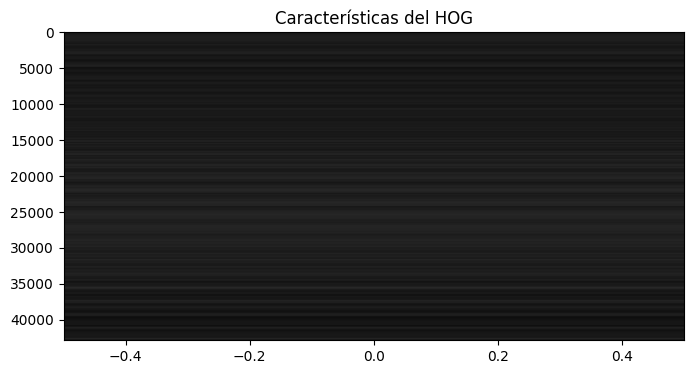

In [30]:
from matplotlib import pyplot as plt
from skimage import exposure


image = cv2.imread(dataset_filenames[2])

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

#Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [25]:
def show_image_with_features(descriptor, image_path):
    features = extract_features(image_path, descriptor)  # Asegúrate de que extract_features devuelva algo

    # Cargar la imagen usando cv2.imread
    original_image = cv2.imread(image_path)

    # Mostrar la imagen original
    cv2.imshow('Original Image', original_image)

    # Mostrar la imagen con las características del descriptor aplicadas
    visualized_image = np.zeros_like(original_image)
    visualized_image[:features.shape[0], :features.shape[1]] = features
    cv2.imshow(f'{descriptor.capitalize()} Features', visualized_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Asegúrate de tener la función extract_features definida y que devuelva algo
# extract_features(image_path, descriptor)

# Llama a la función con la ruta de archivo correcta
show_image_with_features("HOG", dataset_filenames[6])

IndexError: tuple index out of range